# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Loading the csv files sourced from [Football-Data.co.uk](http://www.football-data.co.uk/englandm.php)

In [2]:
dfs = []
for i in range(2000, 2018):
    dfs.append(pd.read_csv(f'./epl-csvs/{i}-{str(i + 1)[2:]}.csv', error_bad_lines=False, warn_bad_lines=False))
    print(f'./epl-csvs/{i}-{str(i + 1)[2:]} loaded successfully')

./epl-csvs/2000-01 loaded successfully
./epl-csvs/2001-02 loaded successfully
./epl-csvs/2002-03 loaded successfully
./epl-csvs/2003-04 loaded successfully
./epl-csvs/2004-05 loaded successfully
./epl-csvs/2005-06 loaded successfully
./epl-csvs/2006-07 loaded successfully
./epl-csvs/2007-08 loaded successfully
./epl-csvs/2008-09 loaded successfully
./epl-csvs/2009-10 loaded successfully
./epl-csvs/2010-11 loaded successfully
./epl-csvs/2011-12 loaded successfully
./epl-csvs/2012-13 loaded successfully
./epl-csvs/2013-14 loaded successfully
./epl-csvs/2014-15 loaded successfully
./epl-csvs/2015-16 loaded successfully
./epl-csvs/2016-17 loaded successfully
./epl-csvs/2017-18 loaded successfully


There was an issue with the 2012-13 season csv file but I have hidden the error messages using warn_bad_lines=False. The lines from 259 to 379 have more fields than there are column headings. I took a look at the file and it isn't clear what extra information is given so these games will not be included.

Let's take a look at one of the dataframes created:

In [3]:
print(dfs[0].head(10))

  Div      Date    HomeTeam       AwayTeam  FTHG  FTAG FTR  HTHG  HTAG HTR  \
0  E0  19/08/00    Charlton       Man City     4     0   H     2     0   H   
1  E0  19/08/00     Chelsea       West Ham     4     2   H     1     0   H   
2  E0  19/08/00    Coventry  Middlesbrough     1     3   A     1     1   D   
3  E0  19/08/00       Derby    Southampton     2     2   D     1     2   A   
4  E0  19/08/00       Leeds        Everton     2     0   H     2     0   H   
5  E0  19/08/00   Leicester    Aston Villa     0     0   D     0     0   D   
6  E0  19/08/00   Liverpool       Bradford     1     0   H     0     0   D   
7  E0  19/08/00  Sunderland        Arsenal     1     0   H     0     0   D   
8  E0  19/08/00   Tottenham        Ipswich     3     1   H     2     1   H   
9  E0  20/08/00  Man United      Newcastle     2     0   H     1     0   H   

   ...   IWA   LBH   LBD   LBA   SBH   SBD   SBA   WHH   WHD   WHA  
0  ...   2.7  2.20  3.25  2.75  2.20  3.25  2.88  2.10  3.20  3.10  
1  

This one has 45 different variables. After looking at the accompanying notes file we can see that many of them are betting odds from the big getting companies in the UK. These columns could be useful for prediction as they are available before the game has taken place. The match statistics such as goals scored, shots, yellow cards and red cards will be used to classify a game as being exciting or not.

# Data Cleaning

The cell below finds the columns that the dataframes have in common so we may combine all the dataframes into a single one.

In [4]:
cols_in_common = set(dfs[0].columns)
for df in dfs[1:]:
    cols_in_common = cols_in_common.intersection(set(df.columns))
print(cols_in_common)

{'HTHG', 'HS', 'AST', 'HR', 'Div', 'AR', 'FTHG', 'Date', 'HTAG', 'HY', 'Referee', 'IWD', 'AY', 'HC', 'AC', 'AwayTeam', 'FTAG', 'IWA', 'HF', 'LBH', 'AF', 'WHA', 'FTR', 'LBD', 'AS', 'LBA', 'HTR', 'HomeTeam', 'WHD', 'WHH', 'IWH', 'HST'}


Here is a description of each of the columns left:

* Div = League Division
* Date = Match Date (dd/mm/yy)
* HomeTeam = Home Team
* AwayTeam = Away Team
* FTHG = Full Time Home Team Goals
* FTAG = Full Time Away Team Goals
* FTR = Full Time Result (H=Home Win, D=Draw, A=Away Win)
* HTHG = Half Time Home Team Goals
* HTAG = Half Time Away Team Goals
* HTR = Half Time Result (H=Home Win, D=Draw, A=Away Win)

Match Statistics:
* Referee = Match Referee
* HS = Home Team Shots
* AS = Away Team Shots
* HST = Home Team Shots on Target
* AST = Away Team Shots on Target
* HC = Home Team Corners
* AC = Away Team Corners
* HF = Home Team Fouls Committed
* AF = Away Team Fouls Committed
* HY = Home Team Yellow Cards
* AY = Away Team Yellow Cards
* HR = Home Team Red Cards
* AR = Away Team Red Cards

Betting Odds:

* IWH = Interwetten home win odds
* IWD = Interwetten draw odds
* IWA = Interwetten away win odds
* LBH = Ladbrokes home win odds
* LBD = Ladbrokes draw odds
* LBA = Ladbrokes away win odds
* WHH = William Hill home win odds
* WHD = William Hill draw odds
* WHA = William Hill away win odds

For the purposes of the model we will keep just the statistics that are considered important to determine whether a game is exciting to watch and one of the betting odds (William Hill) to use for prediction. These are the variables related to goals, result, shots, fouls and cards. The cell below keeps them.

In [5]:
cols_to_keep = ['Date','HomeTeam','AwayTeam',
                'FTHG','FTAG','HS','AS',
                'HST','AST','HTHG','HTAG',
                'HF','AF','FTR','HTR',
                'HY','AY','HR','AR',
                'WHH','WHD','WHA']
df = pd.DataFrame(columns=cols_to_keep)
for frame in dfs:
    df = df.append(frame[list(cols_to_keep)],ignore_index=True,sort=False)
df.sort_values(by='Date',ascending=True)
df.tail(10)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,HS,AS,HST,AST,HTHG,...,AF,FTR,HTR,HY,AY,HR,AR,WHH,WHD,WHA
6679,13/05/18,Burnley,Bournemouth,1,2,12,16,4,5,1,...,9,A,H,0,0,0,0,2.20,3.30,3.50
6680,13/05/18,Crystal Palace,West Brom,2,0,11,7,5,1,0,...,11,H,D,2,3,0,0,1.75,3.60,5.00
6681,13/05/18,Huddersfield,Arsenal,0,1,18,9,3,4,0,...,7,A,A,1,0,0,0,5.50,4.20,1.60
6682,13/05/18,Liverpool,Brighton,4,0,22,2,11,1,2,...,6,H,H,0,0,0,0,1.20,6.50,17.00
6683,13/05/18,Man United,Watford,1,0,7,7,1,3,1,...,11,H,H,4,0,0,0,1.33,5.50,9.00
6684,13/05/18,Newcastle,Chelsea,3,0,16,6,6,2,1,...,10,H,H,0,1,0,0,6.50,4.00,1.57
6685,13/05/18,Southampton,Man City,0,1,8,13,3,2,0,...,10,A,D,3,1,0,0,8.50,4.50,1.40
6686,13/05/18,Swansea,Stoke,1,2,26,8,11,5,1,...,9,A,A,1,2,0,0,1.91,3.75,4.00
6687,13/05/18,Tottenham,Leicester,5,4,14,16,6,9,1,...,13,H,A,1,2,0,0,1.30,6.00,9.00
6688,13/05/18,West Ham,Everton,3,1,15,14,4,7,1,...,13,H,H,0,1,0,0,2.40,3.30,3.10


Now we have all the data required in a single dataframe, let's check for missing entries.

In [6]:
df.isna().sum()

Date          1
HomeTeam      1
AwayTeam      1
FTHG          1
FTAG          1
HS            1
AS            1
HST           1
AST           1
HTHG          1
HTAG          1
HF            1
AF            1
FTR           1
HTR           1
HY            1
AY            1
HR            1
AR            1
WHH         115
WHD         115
WHA         115
dtype: int64

There are some missing entries, so let's drop these.

In [7]:
df.dropna(inplace=True)

In [8]:
df.sample(10)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,HS,AS,HST,AST,HTHG,...,AF,FTR,HTR,HY,AY,HR,AR,WHH,WHD,WHA
1567,04/12/04,Man United,Southampton,3,0,34,4,14,0,0,...,10,H,D,0,1,0,0,1.22,5.00,9.50
6487,17/12/17,West Brom,Man United,1,2,12,8,5,3,0,...,7,A,A,1,3,0,0,6.50,3.80,1.62
2921,13/09/08,Newcastle,Hull,1,2,13,8,4,4,0,...,17,A,A,0,2,1,0,1.70,3.40,5.50
3523,20/02/10,Everton,Man United,3,1,11,11,7,5,1,...,10,H,D,5,1,0,0,4.60,3.25,1.73
4272,11/02/12,Man United,Liverpool,2,1,11,9,6,6,0,...,11,H,D,1,1,0,0,1.91,3.50,4.00
1272,07/01/04,Newcastle,Leeds,1,0,13,9,6,5,1,...,17,H,H,0,1,0,0,1.50,3.40,6.00
4358,14/04/12,Sunderland,Wolves,0,0,15,12,6,8,0,...,11,D,D,0,1,0,0,1.55,3.75,6.50
152,02/12/00,Ipswich,Derby,0,1,11,3,5,3,0,...,13,A,A,1,1,0,0,1.53,3.40,5.50
3511,09/02/10,Man City,Bolton,2,0,8,11,4,5,1,...,18,H,H,0,2,0,0,1.44,4.20,7.50
1854,05/11/05,Arsenal,Sunderland,3,1,12,1,9,1,2,...,13,H,H,0,1,0,0,1.14,6.00,12.00


In [9]:
df.describe()

,WHH,WHD,WHA
count,6574.000000,6574.000000,6574.000000
mean,2.576533,3.602251,4.472852
std,1.574316,0.801931,3.361090
min,1.070000,2.800000,1.140000
25%,1.660000,3.200000,2.500000
50%,2.100000,3.300000,3.300000
75%,2.700000,3.600000,5.000000
max,17.000000,11.000000,26.000000


The output of the cell above is unexpected. Statistics for the betting odds are the only ones that appear. Let's take a look at the datatypes in the dataframe.

In [10]:
df.dtypes

Date         object
HomeTeam     object
AwayTeam     object
FTHG         object
FTAG         object
HS           object
AS           object
HST          object
AST          object
HTHG         object
HTAG         object
HF           object
AF           object
FTR          object
HTR          object
HY           object
AY           object
HR           object
AR           object
WHH         float64
WHD         float64
WHA         float64
dtype: object

We can see that most of the column datatypes are the generic 'object'. Let's change numerical ones to int as that is what they really are.

In [11]:
print(df.sample(10))

            Date     HomeTeam     AwayTeam FTHG FTAG  HS  AS HST AST HTHG  \
458     14/10/01    Blackburn     West Ham    7    1  24  12  14   5    3   
4542    28/11/12  Southampton      Norwich    1    1   8   9   2   5    1   
4854    06/10/13      Norwich      Chelsea    1    3  14  22   3   8    0   
50      16/09/00  Aston Villa     Bradford    2    0  12   8   7   4    1   
1053  26/04/2003   Sunderland    Newcastle    0    1  12  18   8   9    0   
2944    27/09/08        Stoke      Chelsea    0    2   5  14   2   9    0   
2285    09/12/06    Blackburn    Newcastle    1    3  13  16   7   8    0   
1985    04/02/06   Man United       Fulham    4    2  21  10  14   7    3   
465     20/10/01     West Ham  Southampton    2    0  20  10   8   3    0   
4976    29/12/13    Newcastle      Arsenal    0    1  11  11   3   5    0   

      ...   AF FTR HTR HY AY HR AR   WHH   WHD   WHA  
458   ...    6   H   H  1  3  0  1  1.83  3.20  3.75  
4542  ...    7   D   D  1  1  0  0  2.10  

In [12]:
# Infer_objects changes the numerical columns to floats
df = df.infer_objects()
for col in df.columns:
    # The non-betting odds are all ints so let's change them
    if df[col].dtype == 'float64':
        if col not in ['WHH','WHD','WHA']:
            df[col] = df[col].astype(int)
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.dtypes

Date        datetime64[ns]
HomeTeam            object
AwayTeam            object
FTHG                 int32
FTAG                 int32
HS                   int32
AS                   int32
HST                  int32
AST                  int32
HTHG                 int32
HTAG                 int32
HF                   int32
AF                   int32
FTR                 object
HTR                 object
HY                   int32
AY                   int32
HR                   int32
AR                   int32
WHH                float64
WHD                float64
WHA                float64
dtype: object

Now that we have the data in a clean format we can do some analysis to answer some interesting questions. We will also be able to check if the data seems to be accurate by checking these answers independently. 

# Analysis

# Questions that this dataset can answer:

1. Which teams are the highest scorers?
2. Which teams are the lowest scorers?
3. Who has been promoted or relagated to/from the Premier League the most number of times? This means coming in the last 3 teams of the league and moving down to the league below or coming in the top 3 of the league below and coming up.
4. Which team has the biggest difference in goals scored at home versus away?
5. Is there a team who score more away from home? Very unlikely but let's see who is the closest.
6. What is the highest scoring game in the dataset?
7. Which team collected the most yellow cards and red cards?

And here are the answers:

In [13]:
df_home = df[['HomeTeam', 'FTHG']].copy().rename({'HomeTeam':'Team','FTHG':'Goals'},axis=1)
df_away = df[['AwayTeam','FTAG']].copy().rename({'AwayTeam':'Team','FTAG':'Goals'},axis=1)
df_goals = df_home.append(df_away)
df_goals['Goals'] = df_goals['Goals'].astype(int)
df_goals.groupby('Team').sum().sort_values('Goals',ascending=False)[:5]


,Goals
Team,
Man United,1252
Arsenal,1251
Chelsea,1231
Liverpool,1144
Man City,1061


These are the top total scorers since the 2000/01 season. All will be familiar, prolific, goal scoring teams to anyone who follows the Premier League.

In [14]:
df_goals.groupby('Team').sum().sort_values('Goals')[:5]

,Goals
Team,
Huddersfield,28
Bradford,30
Cardiff,32
Sheffield United,32
Brighton,34


These teams are the lowest total goal scorers but this is a little unfair as all these teams only participated in one season up to 2017-18. Let's take a look at the mean number of goals scored a game.

In [15]:
df_goals.groupby('Team').mean().sort_values('Goals')[:5]

,Goals
Team,
Huddersfield,0.736842
Bradford,0.789474
Derby,0.825243
Cardiff,0.842105
Sheffield United,0.842105


It is almost the same teams except for the introduction of Derby (who have participated in a lot of Premier League seasons but only 3 in this dataset) and the ommision of Brighton.

Here are the highest averages:

In [16]:
df_goals.groupby('Team').mean().sort_values('Goals',ascending=False)[:5]

,Goals
Team,
Man United,1.905632
Arsenal,1.904110
Chelsea,1.873668
Liverpool,1.733333
Man City,1.711290


Which agrees with the highest totals which must be the case as all these teams have participated in every season of the Premier League so highest total => highest mean.

In [17]:
# This function returns the season which the game took place
# in as a string with the final 2 digits of the first year
# of the season. So '2007/08' => '07'
def get_season(date):
    if 8 <= date.month <= 12:
        return str(date.year)[2:]
    else:
        return str(date.year - 1)[2:]

df['Season'] = df['Date'].apply(get_season)
df_season_team = df[['HomeTeam','Season']]
df_season_team = df_season_team.groupby(by=['HomeTeam','Season']).count().reset_index()

In [18]:
# This function finds the number of times a team has relagated
# or promoted based on a list of the season they were in the EPL
def changes(season_list):
    num_changes = 0
    in_prem = ('00' in season_list)
    for y in ["%02d" % x for x in range(1, 18)]:
        # This is xor so checking if their premiership status has changed
        if in_prem != (y in season_list): 
            num_changes += 1
            in_prem = not in_prem
    return num_changes

# We store the number of relagations or promotions in dictionary
rels_proms = {}
for team in df_season_team.HomeTeam.unique():
    season_list = list(df_season_team[df_season_team['HomeTeam'] == team]['Season'])
    rels_proms[team] = changes(season_list)
    
print(sorted(rels_proms.items(), key=lambda kv: kv[1], reverse=True))

[('West Brom', 7), ('Birmingham', 6), ('Hull', 6), ('Norwich', 6), ('Burnley', 5), ('Middlesbrough', 5), ('Sunderland', 5), ('Leicester', 4), ('Newcastle', 4), ('QPR', 4), ('Reading', 4), ('West Ham', 4), ('Wolves', 4), ('Crystal Palace', 3), ('Derby', 3), ('Watford', 3), ('Blackburn', 2), ('Blackpool', 2), ('Bolton', 2), ('Cardiff', 2), ('Fulham', 2), ('Man City', 2), ('Middlesboro', 2), ('Portsmouth', 2), ('Sheffield United', 2), ('Southampton', 2), ('Wigan', 2), ('Aston Villa', 1), ('Bournemouth', 1), ('Bradford', 1), ('Brighton', 1), ('Charlton', 1), ('Coventry', 1), ('Huddersfield', 1), ('Ipswich', 1), ('Leeds', 1), ('Stoke', 1), ('Swansea', 1), ('Arsenal', 0), ('Chelsea', 0), ('Everton', 0), ('Liverpool', 0), ('Man United', 0), ('Tottenham', 0)]


We can see that according to the data, **West Brom** have been relagated or promoted the most since 2000-01 with 7 times. I have looked up the seasons that West Brom have participated in the Premier League [here](https://www.wikiwand.com/en/List_of_West_Bromwich_Albion_F.C._seasons) and the number of times West Brom have been promoted and relagated is correct (so long as Wiki is accurate). I have manually checked some of the others and they are all correct! This adds to the evidence that the dataset contains accurate entries.

In [19]:
df_home = df[['HomeTeam', 'FTHG']]
df_away = df[['AwayTeam','FTAG']]
home_mean = df_home.groupby(by='HomeTeam').mean()
away_mean = df_away.groupby(by='AwayTeam').mean()

In [20]:
home_mean['FTHG'] - away_mean['FTAG']

HomeTeam
Arsenal             0.531860
Aston Villa         0.113826
Birmingham          0.359804
Blackburn           0.348718
Blackpool           0.263158
Bolton              0.277778
Bournemouth         0.403509
Bradford            0.526316
Brighton            0.736842
Burnley             0.223684
Cardiff             0.421053
Charlton            0.399118
Chelsea             0.593993
Coventry           -0.421053
Crystal Palace      0.071429
Derby               0.275264
Everton             0.558032
Fulham              0.501161
Huddersfield        0.210526
Hull                0.347368
Ipswich             0.105263
Leeds               0.237302
Leicester           0.200669
Liverpool           0.421026
Man City            0.485239
Man United          0.499527
Middlesboro         1.443439
Middlesbrough       0.327623
Newcastle           0.486254
Norwich             0.526882
Portsmouth          0.494296
QPR                 0.087719
Reading             0.139517
Sheffield United    0.842105
South

The above cell shows the difference between the average number of goals scored at home and goals away. The result which stands out is Coventry who on average scored 0.421053 more goals away from home. Coventry have had some issues with their home ground which can be read about [here](https://www.wikiwand.com/en/Coventry_City_F.C.#/Relocating_to_the_Ricoh_Arena) but it is still very surprising to see a team scoring more away from home.

The team who seem to get the greatest advantage from playing at home are Middleboro. I went to watch a game there once and the home fans were quite ferocious.

In [21]:
# We make a copy of this dataframe slice because we will 
# be sorting it and don't want to affect the original one
games = df[['HomeTeam','AwayTeam','Date','FTHG','FTAG']].copy()
games['TotalGoals'] = games['FTHG'] + games['FTAG']
print('This is the highest scoring game:')
print(games.sort_values(by='TotalGoals',ascending=False).iloc[0])
print('\n\nThis game had the highest home score:')
print(games.sort_values(by='FTHG',ascending=False).iloc[0])
print('\n\nThis game had the highest away score:')
print(games.sort_values(by='FTAG',ascending=False).iloc[0])

This is the highest scoring game:
HomeTeam               Man United
AwayTeam                  Arsenal
Date          2011-08-28 00:00:00
FTHG                            8
FTAG                            2
TotalGoals                     10
Name: 4053, dtype: object


This game had the highest home score:
HomeTeam                Tottenham
AwayTeam                    Wigan
Date          2009-11-22 00:00:00
FTHG                            9
FTAG                            1
TotalGoals                     10
Name: 3394, dtype: object


This game had the highest away score:
HomeTeam                     Hull
AwayTeam                Tottenham
Date          2017-05-21 00:00:00
FTHG                            1
FTAG                            7
TotalGoals                      8
Name: 6302, dtype: object


I have verified that these results are correct. There are some higher scoring games but they are outside the dates of the dataset.

In [22]:
home_cards = df[['HomeTeam','HY','HR',]].rename({'HomeTeam':'Team','HY':'Yellow','HR':'Red'})
home_cards.columns = ['Team','Yellow','Red']
away_cards = df[['AwayTeam','AY','AR',]]
away_cards.columns = ['Team','Yellow','Red']
cards = home_cards.append(away_cards,ignore_index=True)
print('The team with the most yellows is:')
print(cards.groupby('Team').sum().sort_values('Yellow',ascending=False).iloc[0])
print('\n\nThe team with the most reds is:')
print(cards.groupby('Team').sum().sort_values('Red',ascending=False).iloc[0])

The team with the most yellows is:
Yellow    1052
Red         55
Name: Chelsea, dtype: int32


The team with the most reds is:
Yellow    912
Red        60
Name: Newcastle, dtype: int32


# Visualising the Data

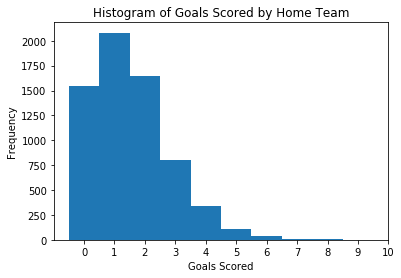

In [23]:
bins = np.arange(0, df['FTHG'].max() + 1.5) - 0.5
fig, ax = plt.subplots()
_ = ax.hist(df['FTHG'], bins, )
ax.set_xticks(bins + 0.5)
ax.set_xlabel('Goals Scored')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Goals Scored by Home Team')
plt.show()

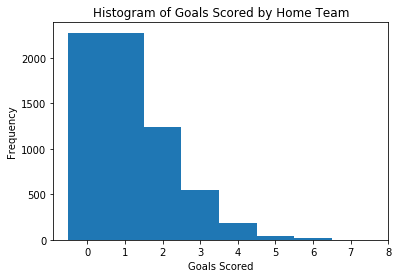

In [24]:
bins = np.arange(0, df['FTAG'].max() + 1.5) - 0.5
fig, ax = plt.subplots()
_ = ax.hist(df['FTAG'], bins)
ax.set_xticks(bins + 0.5)
ax.set_xlabel('Goals Scored')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Goals Scored by Home Team')
plt.show()

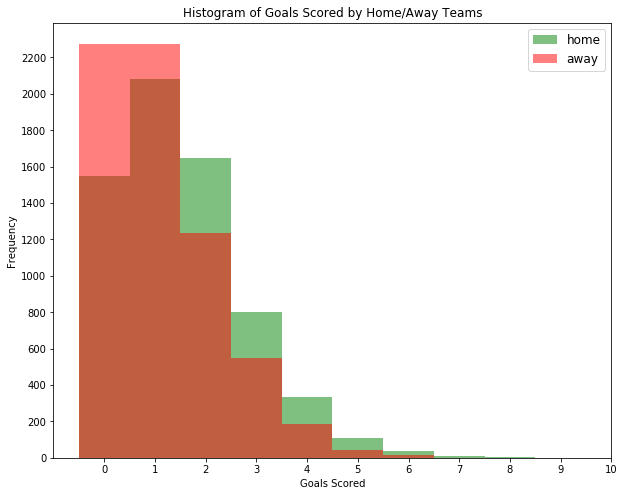

In [25]:
bins = np.arange(0, max(df['FTHG'].max(), df['FTAG'].max()) + 1.5) - 0.5
fig, ax = plt.subplots()
ax.set_xticks(bins + 0.5)
ax.set_yticks(np.arange(0, 2600, 200))
_ = ax.hist(df['FTHG'], bins, alpha=0.5, label='home', color='green')
_ = ax.hist(df['FTAG'], bins, alpha=0.5, label='away', color='red')
plt.legend(loc='upper right', prop={'size': 12})
ax.set_ylabel('Frequency')
plt.xlabel('Goals Scored')
fig.set_size_inches(10,8)
ax.set_title('Histogram of Goals Scored by Home/Away Teams')
plt.show()

This histogram makes the home advantage clear, with the away team far more often goalless than the home team.

Let's take a look at the trend of goal scoring over the seasons. It feels to me that there are more goals scored now, compared to when I was younger but does the data show that?

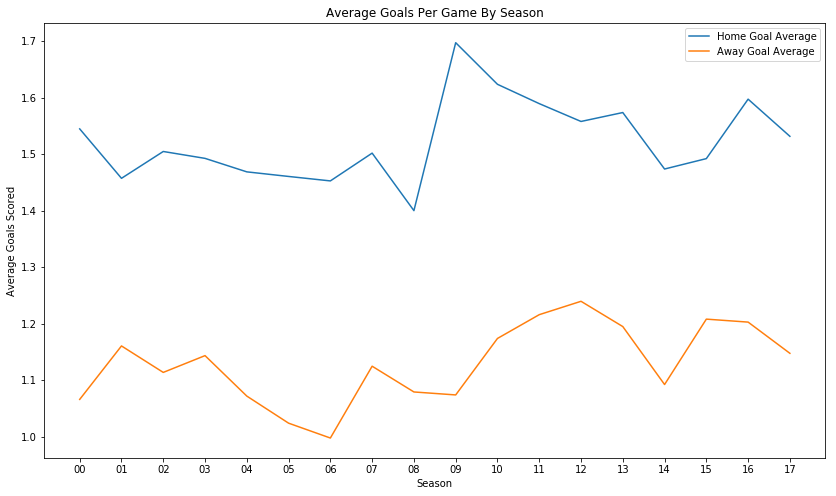

In [26]:
seasons = sorted(df['Season'].unique())
df[['FTHG','FTAG','Season']].groupby(by='Season').mean().plot(figsize=(14,8))
plt.xticks(np.arange(len(seasons)), seasons)
plt.ylabel('Average Goals Scored')
plt.legend(['Home Goal Average', 'Away Goal Average'])
plt.title('Average Goals Per Game By Season')
plt.show()

The graph does not support my gut feeling that there have been more goals scored in recent times. Perhaps slightly for away teams but the trend is not strong. But what about average goals scored without distinguishing between home and away?

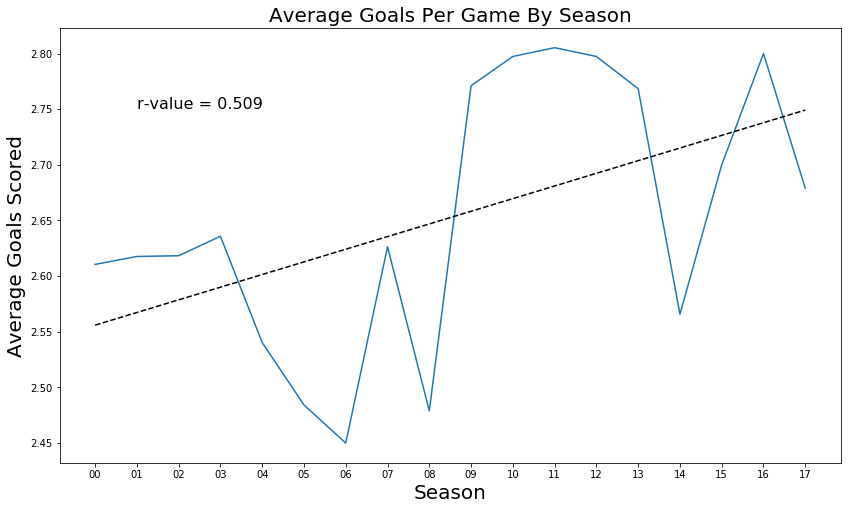

In [27]:
mean_by_season = df[['FTHG','FTAG','Season']].copy()
mean_by_season['Goals'] = mean_by_season['FTHG'] + mean_by_season['FTAG']
y = mean_by_season.groupby('Season')['Goals'].mean()
y.plot(figsize=(14,8))
plt.xticks(np.arange(len(seasons)), seasons)
plt.xlabel('Season', fontsize=20)
plt.ylabel('Average Goals Scored', fontsize=20)
plt.title('Average Goals Per Game By Season', fontsize=20)
fit = np.polyfit(range(18), y, 1)
fit_fn = np.poly1d(fit)
plt.plot(range(18), fit_fn(range(18)), '--k')
corr = round(np.corrcoef(range(18), y)[0,1], 3)
plt.text(x=1, y=2.75, s=f'r-value = {corr}', fontsize=16)
plt.show()

The least squares regression line does show an upwards trend in the average number of goals scored a game with a correlation coefficient of 0.509. The seasons 2009-10 to 2013-14 were clearly good ones to watch for the neutrals with a higher number of goals being scored on average.

I looked up the 2014-15 season and this was one won by Chelsea with only a +41 goal difference. For comparison, this season (2018-19) Manchester City ended with a +72 goal difference.

# Final Data Preperation for Creating the Model

In [28]:
print(df.columns)

Index(['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'HS', 'AS', 'HST',
       'AST', 'HTHG', 'HTAG', 'HF', 'AF', 'FTR', 'HTR', 'HY', 'AY', 'HR', 'AR',
       'WHH', 'WHD', 'WHA', 'Season'],
      dtype='object')


To determine whether a game is worth watching, aka exciting I am going to give various scenarios where I consider a game worth watching. They are:
1. There are 4 goals or more in the gams.
2. There are 3 goals in the game and there were goals in both the first and second half.
3. There were 2 goals and either:
    1. The home and away team had at least 8 shots **on target**. This means there were lots of goal scoring chances and excitement.
    2. The home and away team got at least 5 yellow cards. In this case the game was feisty and hence exciting.
    
Otherwise, I am considering a game not worth watching. The cell below creates an indicator column which is 1 if the game was worth watching and 0 otherwise.

In [29]:
def worth_watching(row):
    four_cond = (row['FTHG'] + row['FTAG'] >= 4)
    
    three_goals = (row['FTHG'] + row['FTAG'] == 3)
    each_half = (0 < row['HTHG'] + row['HTAG'] <= 2)
    three_shots = (row['HST'] >= 6 and row['AST'] >= 6)
    three_cond = three_goals and each_half and three_shots
    
    two_goals = (row['FTHG'] + row['FTAG'] == 2)
    two_shots = (row['HST'] >= 8 and row['AST'] >= 8)
    yellows = (row['HY'] >= 4 and row['AY'] >= 4)    
    two_cond = two_shots and (two_shots or yellows)
    
    return four_cond or three_cond or two_cond

df['watch'] = df.apply(lambda r: 1 if worth_watching(r) else 0, axis=1)

In [30]:
df.sample(100)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,HS,AS,HST,AST,HTHG,...,HTR,HY,AY,HR,AR,WHH,WHD,WHA,Season,watch
6549,2018-01-30,Huddersfield,Liverpool,0,3,5,14,1,7,0,...,A,0,0,0,0,11.00,5.50,1.30,17,0
5402,2015-02-07,QPR,Southampton,0,1,12,16,3,5,0,...,D,2,2,0,0,4.50,3.40,1.85,14,0
5388,2015-01-31,Chelsea,Man City,1,1,3,10,2,5,1,...,D,0,2,0,0,2.15,3.20,3.60,14,0
3044,2008-12-07,Everton,Aston Villa,2,3,12,5,7,5,1,...,D,2,1,0,0,2.62,3.30,2.62,08,1
1078,2003-08-16,Arsenal,Everton,2,1,11,13,5,7,1,...,H,1,3,1,1,1.28,4.50,8.00,03,0
1852,2005-10-30,West Brom,Newcastle,0,3,8,11,4,8,0,...,D,0,1,0,0,2.75,3.10,2.30,05,0
5036,2014-02-09,Man United,Fulham,2,2,31,6,9,3,0,...,A,0,0,0,0,1.22,5.00,21.00,13,1
4090,2011-10-01,Man United,Norwich,2,0,17,13,9,6,0,...,D,1,0,0,0,1.18,7.50,12.00,11,0
2160,2006-09-09,Man United,Tottenham,1,0,10,9,5,4,1,...,H,2,2,0,0,1.50,3.40,6.00,06,0
6402,2017-10-28,Liverpool,Huddersfield,3,0,16,1,8,0,0,...,D,0,1,0,0,1.25,6.50,12.00,17,0


In [31]:
df['watch'].sum()/df['watch'].count()

0.33784606023729846

According to these criteria 33.8\% of games are worth watching. This does feel about right to me.

This new binary classifier column 'watch' is what the model will predict. If we think about predictors we know before the game took place, which may influence the likelihood of a game being exciting these come to mind:
* The current number of goals scored and conceded by both teams in the league so far. Teams who are scoring many goals (and letting in many goals) are likely to have exciting games. I will average these values over the numbers of games the teams have played in the season already.
* Current number of yellow and red cards in the season. Again these will be averaged over the current number of games in the season.
* Proportion of games that have been worth watching in the season so far. If we are half way through the season and most of a team's games have been worth watching, then surely it is likely that their future games will also be worth watching.

Unfortunately, these statistics are not provided explicitly by the dataset. However, with some programming they can be generated.

Please see the comments for an explanation of what is going on

In [32]:
# We make a copy of df because we are going to add new columns
# and we do not want to alter the original DataFrame
df_extra = df.copy()
# Loop over the seasons
for season in df['Season'].unique():
    # Collect the games from this season
    games = df[df['Season'] == season].copy()
    # This table is going to store statistics for the season
    # it will be updated and used after we look at each game
    table = dict()
    # Populate the table with zeros for each team
    for team in games['HomeTeam'].unique():
        # N = Number of games played
        # GS = Goals Scored
        # GA = Goals Against
        # YC = Yellow Cards
        # RC = Red Cards
        # WW = Worth watching
        # All averages
        table[team] = {'N':0, 'GS': 0, 'GA': 0, 'YC':0, 'RC': 0, 'WW': 0}
    # We are going to look at each game in the season and update the table
    # for the teams that are playing
    for index, game in games.iterrows():
        thome = table[game['HomeTeam']]
        taway = table[game['AwayTeam']]        
        thome['GS'] = (thome['GS'] * thome['N'] + game['FTHG']) / (thome['N'] + 1)
        taway['GS'] = (taway['GS'] * taway['N'] + game['FTAG']) / (taway['N'] + 1)
        thome['GA'] = (thome['GA'] * thome['N'] + game['FTAG']) / (thome['N'] + 1)
        taway['GA'] = (taway['GA'] * taway['N'] + game['FTHG']) / (taway['N'] + 1)
        thome['YC'] = (thome['YC'] * thome['N'] + game['HY']) / (thome['N'] + 1)
        taway['YC'] = (taway['YC'] * taway['N'] + game['AY']) / (taway['N'] + 1)
        thome['RC'] = (thome['RC'] * thome['N'] + game['HR']) / (thome['N'] + 1)
        taway['RC'] = (taway['RC'] * taway['N'] + game['AR']) / (taway['N'] + 1)
        thome['WW'] = (thome['WW'] * thome['N'] + game['watch']) / (thome['N'] + 1)
        taway['WW'] = (taway['WW'] * taway['N'] + game['watch']) / (taway['N'] + 1)
        thome['N'] += 1
        taway['N'] += 1
        # Get the next 20 games after the one currently being examined
        # 20 is chosen because occasionally a team will not play for one
        # round due to other commintements. We are guaranteed to find
        # their next game in the next 20 in the league
        df_rem = games.loc[index+1:index+21].copy().reset_index(drop=True)
        # An exception is needed as at the end of the season there 
        # are no future games to populate.
        try:
            # This finds the next game for the current home team
            next_homes = df_rem[(df_rem['HomeTeam'] == game['HomeTeam']) | (df_rem['AwayTeam'] == game['HomeTeam'])]
            next_home = next_homes.copy().reset_index(drop=True).iloc[0]
            next_aways = df_rem[(df_rem['HomeTeam'] == game['AwayTeam']) | (df_rem['AwayTeam'] == game['AwayTeam'])]
            next_away = next_aways.copy().reset_index(drop=True).iloc[0]
            # If the current home team are playing next as the home team put the relevant 
            # statistics into that row of the DataFrame
            if next_home['HomeTeam'] == game['HomeTeam']:
                # This finds the index in the original DataFrame of the next game for the 
                # team who are at home currently
                i = ((df_extra['Date'] == next_home['Date']) & (df_extra['HomeTeam'] == next_home['HomeTeam']))
                df_extra.loc[i, 'HGS'] = table[next_home['HomeTeam']]['GS']
                df_extra.loc[i, 'HGA'] = table[next_home['HomeTeam']]['GA']
                df_extra.loc[i, 'HYC'] = table[next_home['HomeTeam']]['YC']
                df_extra.loc[i, 'HRC'] = table[next_home['HomeTeam']]['RC']
                df_extra.loc[i, 'HWW'] = table[next_home['HomeTeam']]['WW']
            else:
                i = (df_extra['Date'] == next_home['Date']) & (df_extra['AwayTeam'] == next_home['AwayTeam'])
                df_extra.loc[i, 'AGS'] = table[next_home['AwayTeam']]['GS']
                df_extra.loc[i, 'AGA'] = table[next_home['AwayTeam']]['GA']
                df_extra.loc[i, 'AYC'] = table[next_home['AwayTeam']]['YC']
                df_extra.loc[i, 'ARC'] = table[next_home['AwayTeam']]['RC']
                df_extra.loc[i, 'AWW'] = table[next_home['AwayTeam']]['WW']
            if next_away['AwayTeam'] == game['AwayTeam']:
                # This finds the index in the original DataFrame of the next game for the 
                # team who are away currently
                i = (df_extra['Date'] == next_away['Date']) & (df_extra['AwayTeam'] == next_away['AwayTeam'])
                df_extra.loc[i, 'AGS'] = table[next_away['AwayTeam']]['GS']
                df_extra.loc[i, 'AGA'] = table[next_away['AwayTeam']]['GA']
                df_extra.loc[i, 'AYC'] = table[next_away['AwayTeam']]['YC']
                df_extra.loc[i, 'ARC'] = table[next_away['AwayTeam']]['RC']
                df_extra.loc[i, 'AWW'] = table[next_away['AwayTeam']]['WW']
            else:
                i = (df_extra['Date'] == next_away['Date']) & (df_extra['HomeTeam'] == next_away['HomeTeam'])
                df_extra.loc[i, 'HGS'] = table[next_away['HomeTeam']]['GS']
                df_extra.loc[i, 'HGA'] = table[next_away['HomeTeam']]['GA']
                df_extra.loc[i, 'HYC'] = table[next_away['HomeTeam']]['YC']
                df_extra.loc[i, 'HRC'] = table[next_away['HomeTeam']]['RC']
                df_extra.loc[i, 'HWW'] = table[next_away['HomeTeam']]['WW']
        # Just pass as there is nothing to do in this case as the team have
        # no more games in the season
        except IndexError:
            pass
    # Print statement as this code takes some time to run
    print(f'Season: {season} done!')    

Season: 00 done!
Season: 01 done!
Season: 02 done!
Season: 03 done!
Season: 04 done!
Season: 05 done!
Season: 06 done!
Season: 07 done!
Season: 08 done!
Season: 09 done!
Season: 10 done!
Season: 11 done!
Season: 12 done!
Season: 13 done!
Season: 14 done!
Season: 15 done!
Season: 16 done!
Season: 17 done!


Let's take a look at some season to see the statistics entered. Some are filled in as NaN beacuase they are at the beginning of a season. The model is not going to be able to predict whether a game is worth watching if the team has not played yet.

In [33]:
df_extra[df_extra['Season'] == '01'].sample(20)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,HS,AS,HST,AST,HTHG,...,AGS,AGA,AYC,ARC,AWW,HGS,HGA,HYC,HRC,HWW
748,2002-05-08,Liverpool,Blackburn,4,3,15,9,7,7,2,...,1.314286,1.257143,1.485714,0.114286,0.228571,1.611111,0.750000,1.111111,0.083333,0.222222
569,2001-12-29,Aston Villa,Tottenham,1,1,12,7,7,4,0,...,1.555556,1.388889,1.611111,0.166667,0.388889,1.388889,1.166667,0.944444,0.111111,0.388889
617,2002-01-30,Liverpool,Leicester,1,0,11,3,4,0,0,...,0.652174,1.739130,2.130435,0.217391,0.347826,1.375000,1.000000,1.208333,0.125000,0.250000
558,2001-12-26,Arsenal,Chelsea,2,1,11,9,7,3,0,...,1.555556,0.722222,2.111111,0.166667,0.277778,2.000000,1.117647,2.764706,0.294118,0.411765
646,2002-02-23,West Ham,Middlesbrough,1,0,12,7,8,4,0,...,1.000000,1.280000,1.320000,0.160000,0.240000,1.160000,1.600000,2.000000,0.120000,0.280000
443,2001-09-29,Everton,West Ham,5,0,18,15,11,5,1,...,0.800000,0.800000,3.200000,0.200000,0.000000,1.166667,1.666667,1.833333,0.000000,0.333333
655,2002-03-02,Newcastle,Arsenal,0,2,13,9,6,6,0,...,2.000000,1.076923,2.461538,0.230769,0.384615,1.840000,1.280000,1.600000,0.080000,0.480000
457,2001-10-14,Aston Villa,Fulham,2,0,9,11,3,3,0,...,1.000000,1.142857,1.428571,0.000000,0.285714,1.500000,0.500000,1.166667,0.166667,0.333333
532,2001-12-09,Blackburn,Leeds,1,2,14,10,6,7,0,...,1.142857,0.571429,1.928571,0.214286,0.142857,1.285714,1.000000,1.642857,0.071429,0.142857
599,2002-01-19,Leicester,Newcastle,0,0,8,9,4,3,0,...,1.800000,1.400000,1.800000,0.100000,0.450000,0.666667,1.761905,2.142857,0.238095,0.333333


Let's do a final check for NA values. There should be 10 per season due to the fact that we don't have statistics for the first game of each team. So we expect 180. It turns out there are 254 so out of over 6000 games that is not many. Perhaps at some point I will examine why these exist and wether they are fixable but for now I will just exclude them.

In [34]:
df_extra.isna().sum()

Date          0
HomeTeam      0
AwayTeam      0
FTHG          0
FTAG          0
HS            0
AS            0
HST           0
AST           0
HTHG          0
HTAG          0
HF            0
AF            0
FTR           0
HTR           0
HY            0
AY            0
HR            0
AR            0
WHH           0
WHD           0
WHA           0
Season        0
watch         0
AGS         254
AGA         254
AYC         254
ARC         254
AWW         254
HGS         258
HGA         258
HYC         258
HRC         258
HWW         258
dtype: int64

I am going to write this prepared Pandas DataFrame to a csv file and fit the model in a new notebook as this one is now a little long.

In [35]:
df_extra.dropna(inplace=True)
df_extra.reset_index(inplace=True)
df_extra['watch'] = pd.to_numeric(df_extra['watch'])
df_extra.to_csv('clean_data.csv',sep='\t',encoding='utf-8')